## TOPIC ANALYSIS

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
    
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 

In [1156]:
from wordcloud import WordCloud, STOPWORDS

import pandas as pd

from pprint import pprint

import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy

import pyLDAvis
import pyLDAvis.gensim 

from gensim.models import Word2Vec
from nltk.stem import PorterStemmer 

stop_words = stopwords.words('english')
stop_words += ['from', 'subject', 're', 'edu', 'use','user', 'com', 'co', 'con', 'be', 'else', 'http', 'would','send', 
                   'do', 'try', 'tell', 'go', 'get', 'can', 'think', 'know', 'give', 'ask', 
               'next', 'find', 're']

In [994]:
def remove_stopwords(texts):
    stop_words = stopwords.words('english')
    stop_words += ['from', 'subject', 're', 'edu', 'use','user', 'com', 'co', 'con', 'be', 'else', 'http', 'would','send', 
                   'do', 'try', 'tell', 'go', 'get', 'can', 'think', 'know', 'give', 'ask', 
               'next', 'find', 're']
    return [[word for word in simple_preprocess(str(doc)) if word.strip() not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def stem_and_lemmatize(tweet):
    tweet = ' '.join(tweet)
    stem = PorterStemmer().stem(tweet)
    return WordNetLemmatizer().lemmatize(stem)

### Getting the dataset

In [995]:
cdf = pd.read_csv('cdf.csv')

In [996]:
cdf['PM'].value_counts()/len(cdf)

none             0.901269
Boris Johnson    0.053743
Theresa May      0.044988
Name: PM, dtype: float64

In [997]:
#reducing dataset from 300k to 50k (removing 90% of the none values)
#cdf = cdf.drop(cdf[cdf['PM'] == 'none'].sample(frac=.98).index)
df = cdf.drop(cdf[(cdf.PM == 'none')].index)

In [998]:
df.dropna(inplace=True)

In [999]:
df['PM'].value_counts()

Boris Johnson    16407
Theresa May      13735
Name: PM, dtype: int64

In [1000]:
df.drop_duplicates(subset='TEXT', inplace=True)

In [1001]:
df

,MONTH_INT,MONTH_STR,USERNAME,TEXT,TWEET_PROCESSED,TWEET_CLEANED,PM
7,7,Jul,Macetrain,Nicola Sturgeon tells Boris Johnson: Brexit of...,"['nicola', 'sturgeon', 'tells', 'boris', 'john...",nicola sturgeon tells boris johnson brexit off...,Boris Johnson
9,7,Jul,DerekJa09788684,If we ever get brexit.and Boris is looking mor...,"['ever', 'brexit', 'boris', 'looking', 'dodgy'...",ever brexit boris looking dodgy continental qu...,Boris Johnson
12,7,Jul,johnleremainer,Media have finally realised that Brexit will b...,"['media', 'finally', 'realised', 'brexit', 'di...",media finally realised brexit disaster johnson...,Boris Johnson
22,7,Jul,Endoxa66,@BorisJohnson this better be a joke or else yo...,"['borisjohnson', 'better', 'joke', 'else', 'to...",borisjohnson better joke else tories toast bre...,Boris Johnson
24,7,Jul,KamalJoshi108,"""Turbo-charge"" Brexit plans, with ""all necessa...","['turbo', 'charge', 'brexit', 'plans', 'necess...",turbo charge brexit plans necessary funding pr...,Boris Johnson
...,...,...,...,...,...,...,...
305173,2,Feb,guardian,The Guardian view on Boris Johnson in court: B...,"['guardian', 'view', 'boris', 'johnson', 'cour...",guardian view boris johnson court brexit editori,Boris Johnson
305174,2,Feb,Col_Bogey,"Johnson is Trump's poodle -- a weak, unpatriot...","['johnson', 'trump', 'poodle', 'weak', 'unpatr...",johnson trump poodle weak unpatriotic irritati...,Boris Johnson
305179,2,Feb,PoetintheWoods,Poet in the Woods: The Voice of Many? https://...,"['poet', 'woods', 'voice', 'many', 'brexit', '...",poet woods voice many brexit boris muddling co...,Boris Johnson
305213,2,Feb,cpseed,"I don't need to learn anything about Brexit, I...","['need', 'learn', 'anything', 'brexit', 'fully...",need learn anything brexit fully understand tr...,Boris Johnson


In [1002]:
df_march = df[(df.MONTH_STR == 'Mar')]
df_april = df[(df.MONTH_STR == 'Apr')]
df_june = df[(df.MONTH_STR == 'Jun')] 
df_july = df[(df.MONTH_STR == 'Jul')] 
df_nov = df[(df.MONTH_STR == 'Nov')] 
df_dec = df[(df.MONTH_STR == 'Dec')]

In [1003]:
df_march = df_march.append(df_april)
df_july = df_june.append(df_july)
df_nov = df_nov.append(df_dec)

In [1004]:
df_2.MONTH_STR.value_counts()

Jul    2031
Jun    1555
Name: MONTH_STR, dtype: int64

In [1005]:
#df_m = df[df['PM'] == 'Theresa May']
#df_b = df[df['PM'] == 'Boris Johnson']
#df_tm = df_m['TWEET_CLEANED'].tolist()
#df_bj = df_b['TWEET_CLEANED'].tolist()
df_march = df_march['TWEET_CLEANED'].tolist()
df_july = df_july['TWEET_CLEANED'].tolist()
df_nov = df_nov['TWEET_CLEANED'].tolist()

In [1006]:
df_march

['realdonaldtrump thinks theresa taken advice suppose done government would shut long brexit',
 'hoodwinked voting promise brexit sarahwollaston theresa may conservatives betrayed fellow patriotic brits goodbye demorcracy country proudly served protect',
 'irreconcilables waverers converts fate theresa brexit deal lies hands eurosceptics telegraph',
 'brexit labour leaver demand future talks price backing theresa deal new',
 'james gray feels forced vote theresa may obnoxious deal fear losing brexit spitting feathers reduced brexit vote stevebakerhw johnredwood owenpaterson asabenn tnewtondunn iaindal',
 'anybody else thinks theresa beginning chance pushing deal next week week probably brexit hard suddenly hard week ahead',
 'daily mail quite poll shows tory voters want save theresa brexit deal mailonlin',
 'brexit labour leaver demand future talks price backing theresa',
 'called comedians giving relief theresa would brexit comical look runs country kill brexit sure money would break 

In [1007]:
df

,MONTH_INT,MONTH_STR,USERNAME,TEXT,TWEET_PROCESSED,TWEET_CLEANED,PM
7,7,Jul,Macetrain,Nicola Sturgeon tells Boris Johnson: Brexit of...,"['nicola', 'sturgeon', 'tells', 'boris', 'john...",nicola sturgeon tells boris johnson brexit off...,Boris Johnson
9,7,Jul,DerekJa09788684,If we ever get brexit.and Boris is looking mor...,"['ever', 'brexit', 'boris', 'looking', 'dodgy'...",ever brexit boris looking dodgy continental qu...,Boris Johnson
12,7,Jul,johnleremainer,Media have finally realised that Brexit will b...,"['media', 'finally', 'realised', 'brexit', 'di...",media finally realised brexit disaster johnson...,Boris Johnson
22,7,Jul,Endoxa66,@BorisJohnson this better be a joke or else yo...,"['borisjohnson', 'better', 'joke', 'else', 'to...",borisjohnson better joke else tories toast bre...,Boris Johnson
24,7,Jul,KamalJoshi108,"""Turbo-charge"" Brexit plans, with ""all necessa...","['turbo', 'charge', 'brexit', 'plans', 'necess...",turbo charge brexit plans necessary funding pr...,Boris Johnson
...,...,...,...,...,...,...,...
305173,2,Feb,guardian,The Guardian view on Boris Johnson in court: B...,"['guardian', 'view', 'boris', 'johnson', 'cour...",guardian view boris johnson court brexit editori,Boris Johnson
305174,2,Feb,Col_Bogey,"Johnson is Trump's poodle -- a weak, unpatriot...","['johnson', 'trump', 'poodle', 'weak', 'unpatr...",johnson trump poodle weak unpatriotic irritati...,Boris Johnson
305179,2,Feb,PoetintheWoods,Poet in the Woods: The Voice of Many? https://...,"['poet', 'woods', 'voice', 'many', 'brexit', '...",poet woods voice many brexit boris muddling co...,Boris Johnson
305213,2,Feb,cpseed,"I don't need to learn anything about Brexit, I...","['need', 'learn', 'anything', 'brexit', 'fully...",need learn anything brexit fully understand tr...,Boris Johnson


## Preparing the text

### Creating a dictionary out of bigrams

#### March

In [1073]:
bigram_m = gensim.models.Phrases(df_march, min_count=10, threshold=1) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram_m)

In [1074]:
#remove Stop Words
data_words_nostops = remove_stopwords(df_march)
#creating bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_m = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB', 'ADJ'])

In [1075]:
print(data_lemmatized_m[:1][0][:30])

['realdonaldtrump', 'think', 'take', 'advice', 'suppose', 'do', 'government', 'shut', 'long']


In [1076]:
# Create Dictionary from the unique bigrams 
id2word_m = corpora.Dictionary(data_lemmatized_m)
id2word_m.filter_extremes(no_below=100, no_above=0.5) #excluding tokens that ocurred in less than 10 tweets and bigrams that occurred in more than 50% of the tweets
# Rebuild corpus based on the dictionary
texts_m = data_lemmatized_m
for i in texts_m:
    for k in i:
        remove = ['from', 'subject', 're', 'edu', 'use','user', 'com', 'co', 'con', 'be', 'else', 'http', 'would','send', 
                   'do', 'try', 'tell', 'go', 'get', 'can', 'think', 'know', 'give', 'ask', 's',
               'next', 'find', 're', 'semi','week', 'day', 'want', 'mail', 'run', 'ree', 'other', 'many', 'day', 'year']
        if k in remove:
            i.remove(k)
# Term Document Frequency
corpus_m = [id2word_m.doc2bow(text) for text in texts_m]

#### July

In [1016]:
#remove Stop Words
data_words_nostops = remove_stopwords(df_july)
#creating bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_j = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB', 'ADJ'])

In [1017]:
print(data_lemmatized_j[:1][0][:30])

['perspective', 'likely', 'deal', 'accord']


In [1018]:
# Create Dictionary from the unique bigrams 
id2word_j = corpora.Dictionary(data_lemmatized_j)
id2word_j.filter_extremes(no_below=200)#, no_above=0.5) #excluding tokens that ocurred in less than 10 tweets and bigrams that occurred in more than 50% of the tweets
# Rebuild corpus based on the dictionary
texts_j = data_lemmatized_j
for i in texts_j:
    for k in i:
        remove = ['from', 'subject', 're', 'edu', 'use','user', 'com', 'co', 'con', 'be', 'else', 'http', 'would','send', 
                   'do', 'try', 'tell', 'go', 'get', 'can', 'think', 'know', 'give', 'ask', 's',
               'next', 'find', 're', 'semi','week', 'day', 'want', 'mail', 'run', 'ree', 'other', 'many', 'day', 'year']
        if k in remove:
            i.remove(k)
# Term Document Frequency
corpus_j = [id2word_j.doc2bow(text) for text in texts_j]

### November

In [1019]:
bigram_n = gensim.models.Phrases(df_nov, min_count=10, threshold=1) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram_n)

In [1020]:
#remove Stop Words
data_words_nostops = remove_stopwords(df_nov)
#creating bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_n = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB', 'ADJ'])

In [1021]:
print(data_lemmatized_n[:1][0][:30])

['corbyn', 'supporter', 'check', 'remainer', 'need', 'hold', 'nose', 'good', 'judgement', 'stop', 'get', 'majority', 'ensure', 'deal', 'brexit', 'good', 'site', 'compare', 'tactical', 'voting', 'sit']


In [1022]:
# Create Dictionary from the unique bigrams 
id2word_n = corpora.Dictionary(data_lemmatized_n)
id2word_n.filter_extremes(no_below=200)#, no_above=0.5) #excluding tokens that ocurred in less than 10 tweets and bigrams that occurred in more than 50% of the tweets
# Rebuild corpus based on the dictionary
texts_n = data_lemmatized_n
for i in texts_n:
    for k in i:
        remove = ['from', 's','subject', 're', 'edu', 'use','user', 'com', 'co', 'con', 'be', 'else', 'http', 'would','send', 
                   'do', 'try', 'tell', 'go', 'get', 'can', 'think', 'know', 'give', 'ask', 
               'next', 'find', 're', 'semi','week', 'day', 'want', 'mail', 'run', 'ree', 'other', 'many', 'day', 'year']
        if k in remove:
            i.remove(k)
# Term Document Frequency
corpus_n = [id2word_n.doc2bow(text) for text in texts_n]

### Using TF-IDF

#### A problem with this approach is that highly frequent words start to dominate in the document, but may not be representative to the model as less-frequent words. One way to fix this is to measure how unique (or how infrequent) a word is across all documents (or tweets), which is called the “inverse document frequency” or IDF. By introducing IDF, frequent words that are also frequent across all documents get penalized with less weight.
https://towardsdatascience.com/topic-modeling-of-2019-hr-tech-conference-twitter-d16cf75895b6

### March

In [1126]:
tfidf = models.TfidfModel(corpus_m)
tfidf_corpus_m = tfidf[corpus_m]

In [1030]:
w2v_model_m = Word2Vec(min_count=30,
                     window=5,
                     size=100,
                     workers=4)

In [1031]:
w2v_model_m.build_vocab(texts_m)         #building the vocabulary (from the tweets) for the model
w2v_model_m.train(corpus_m, total_examples=w2v_model_m.corpus_count, epochs=w2v_model_m.iter)
w2v_model_m.init_sims(replace=True)

In [1034]:
w2v_model_m.wv.vocab

{'take': <gensim.models.keyedvectors.Vocab at 0x12b8e6590>,
 'government': <gensim.models.keyedvectors.Vocab at 0x12b8e1810>,
 'long': <gensim.models.keyedvectors.Vocab at 0x12b8e1c50>,
 'voting': <gensim.models.keyedvectors.Vocab at 0x12b8e1d10>,
 'promise': <gensim.models.keyedvectors.Vocab at 0x12b8e3c90>,
 'may': <gensim.models.keyedvectors.Vocab at 0x12b8e0310>,
 'conservative': <gensim.models.keyedvectors.Vocab at 0x12b8d7e50>,
 'betray': <gensim.models.keyedvectors.Vocab at 0x12b8db490>,
 'country': <gensim.models.keyedvectors.Vocab at 0x12b8eab10>,
 'serve': <gensim.models.keyedvectors.Vocab at 0x12b8e0250>,
 'lie': <gensim.models.keyedvectors.Vocab at 0x12b8dac50>,
 'hand': <gensim.models.keyedvectors.Vocab at 0x142c66850>,
 'telegraph': <gensim.models.keyedvectors.Vocab at 0x12b6487d0>,
 'demand': <gensim.models.keyedvectors.Vocab at 0x14f145110>,
 'future': <gensim.models.keyedvectors.Vocab at 0x14ebd3750>,
 'talk': <gensim.models.keyedvectors.Vocab at 0x10b002610>,
 'theres

In [1033]:
w2v_model_m.wv.most_similar(positive=['theresa'])

[('wait', 0.2465851753950119),
 ('suffer', 0.23838959634304047),
 ('country', 0.23454290628433228),
 ('british', 0.215613454580307),
 ('people', 0.20508936047554016),
 ('local', 0.20150874555110931),
 ('leadership', 0.19284167885780334),
 ('betrayal', 0.18718093633651733),
 ('keep', 0.174340158700943),
 ('work', 0.1738782525062561)]

In [1035]:
w2v_model_m.wv.most_similar(positive=['borisjohnson'])

[('issue', 0.2649805545806885),
 ('tomorrow', 0.24230065941810608),
 ('public', 0.24182233214378357),
 ('withdrawal', 0.23633530735969543),
 ('home', 0.21783706545829773),
 ('water', 0.2154776155948639),
 ('resign', 0.21202710270881653),
 ('throw', 0.20458173751831055),
 ('ignore', 0.19937244057655334),
 ('become', 0.19378376007080078)]

In [1036]:
w2v_model_m.wv.most_similar(positive=['brexit'])

[('video', 0.31992843747138977),
 ('walk', 0.3153870105743408),
 ('report', 0.27339863777160645),
 ('member', 0.26000407338142395),
 ('british', 0.23872078955173492),
 ('push', 0.23155272006988525),
 ('hope', 0.23024486005306244),
 ('happen', 0.22619986534118652),
 ('failure', 0.22475531697273254),
 ('majority', 0.20917320251464844)]

In [1037]:
tfidf = models.TfidfModel(corpus_j)
tfidf_corpus_j = tfidf[corpus_j]
w2v_model_j = Word2Vec(min_count=30,
                     window=5,
                     size=100,
                     workers=4)
w2v_model_j.build_vocab(texts_j)         #building the vocabulary (from the tweets) for the model
w2v_model_j.train(texts, total_examples=w2v_model_j.corpus_count, epochs=w2v_model_j.iter)
w2v_model_j.init_sims(replace=True)
#w2v_model_j.wv.vocab

In [1038]:
w2v_model_j.wv.most_similar(positive=['theresa'])

[('people', 0.9988583922386169),
 ('corbyn', 0.9988306164741516),
 ('stand', 0.9988200664520264),
 ('work', 0.9988133907318115),
 ('tory', 0.9988077282905579),
 ('keep', 0.9988007545471191),
 ('vote', 0.9987981915473938),
 ('labour', 0.998790979385376),
 ('deal', 0.9987883567810059),
 ('conservative', 0.9987854957580566)]

In [1039]:
w2v_model_j.wv.most_similar(positive=['borisjohnson'])

[('majority', 0.999771773815155),
 ('labour', 0.999761164188385),
 ('brexit', 0.9997607469558716),
 ('lose', 0.9997574090957642),
 ('corbyn', 0.9997448921203613),
 ('vote', 0.9997358322143555),
 ('leave', 0.999724268913269),
 ('deal', 0.9997240900993347),
 ('tory', 0.9997239112854004),
 ('time', 0.999716579914093)]

In [1041]:
w2v_model_j.wv.most_similar(positive=['brexit'])

[('majority', 0.9999037981033325),
 ('labour', 0.999885618686676),
 ('vote', 0.9998733997344971),
 ('leave', 0.9998583197593689),
 ('tory', 0.9998534917831421),
 ('corbyn', 0.9998534321784973),
 ('deal', 0.9998407363891602),
 ('remain', 0.9998321533203125),
 ('party', 0.9998290538787842),
 ('stop', 0.9998284578323364)]

In [1042]:
tfidf = models.TfidfModel(corpus_n)
tfidf_corpus_n = tfidf[corpus_n]
w2v_model_n = Word2Vec(min_count=20,
                     window=5,
                     size=100,
                     workers=4)
w2v_model_n.build_vocab(texts_n)         #building the vocabulary (from the tweets) for the model
w2v_model_n.train(tfidf_corpus_n, total_examples=w2v_model_n.corpus_count, epochs=w2v_model.iter)
w2v_model_n.init_sims(replace=True)
#w2v_model_n.wv.vocab

In [1043]:
w2v_model_n.wv.most_similar(positive=['brexit'])

[('video', 0.31992843747138977),
 ('walk', 0.3153870105743408),
 ('document', 0.2749285101890564),
 ('report', 0.27339863777160645),
 ('member', 0.26000407338142395),
 ('british', 0.23872078955173492),
 ('beautiful', 0.2324807494878769),
 ('push', 0.23155272006988525),
 ('wish', 0.23113590478897095),
 ('hope', 0.23024486005306244)]

In [1044]:
w2v_model_n.wv.most_similar(positive=['theresa'])

[('grow', 0.2518830895423889),
 ('wait', 0.2465851753950119),
 ('citizen', 0.24154247343540192),
 ('country', 0.23454290628433228),
 ('area', 0.23106534779071808),
 ('british', 0.215613454580307),
 ('realise', 0.20657962560653687),
 ('people', 0.20508936047554016),
 ('local', 0.20150874555110931),
 ('hume', 0.19593815505504608)]

In [1045]:
w2v_model_n.wv.most_similar(positive=['borisjohnson'])

[('issue', 0.2649805545806885),
 ('pact', 0.2517128586769104),
 ('tomorrow', 0.24230065941810608),
 ('public', 0.24182233214378357),
 ('withdrawal', 0.23633530735969543),
 ('home', 0.21783706545829773),
 ('water', 0.2154776155948639),
 ('throw', 0.20458173751831055),
 ('ignore', 0.19937244057655334),
 ('become', 0.19378376007080078)]

In [1046]:
w2v_model_m.wv.most_similar(positive=['brexit'])

[('video', 0.31992843747138977),
 ('walk', 0.3153870105743408),
 ('report', 0.27339863777160645),
 ('member', 0.26000407338142395),
 ('british', 0.23872078955173492),
 ('push', 0.23155272006988525),
 ('hope', 0.23024486005306244),
 ('happen', 0.22619986534118652),
 ('failure', 0.22475531697273254),
 ('majority', 0.20917320251464844)]

In [1047]:
w2v_model_j.wv.most_similar(positive=['brexit'])

[('majority', 0.9999037981033325),
 ('labour', 0.999885618686676),
 ('vote', 0.9998733997344971),
 ('leave', 0.9998583197593689),
 ('tory', 0.9998534917831421),
 ('corbyn', 0.9998534321784973),
 ('deal', 0.9998407363891602),
 ('remain', 0.9998321533203125),
 ('party', 0.9998290538787842),
 ('stop', 0.9998284578323364)]

In [1048]:
w2v_model_n.wv.most_similar(positive=['brexit'])

[('video', 0.31992843747138977),
 ('walk', 0.3153870105743408),
 ('document', 0.2749285101890564),
 ('report', 0.27339863777160645),
 ('member', 0.26000407338142395),
 ('british', 0.23872078955173492),
 ('beautiful', 0.2324807494878769),
 ('push', 0.23155272006988525),
 ('wish', 0.23113590478897095),
 ('hope', 0.23024486005306244)]

## Topic Modeling Via LDA

In [1059]:
lda_model_m = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=id2word_m,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [1060]:
# Print the Keyword in the 10 topics
pprint(lda_model_m.print_topics())
doc_lda_m = lda_model_m[corpus]

[(0,
  '0.176*"tory" + 0.161*"make" + 0.108*"support" + 0.094*"good" + 0.082*"stop" '
  '+ 0.081*"come" + 0.081*"government" + 0.057*"change" + 0.054*"mean" + '
  '0.049*"believe"'),
 (1,
  '0.224*"may" + 0.209*"theresa" + 0.116*"brexit" + 0.040*"remain" + '
  '0.039*"need" + 0.037*"face" + 0.034*"country" + 0.034*"agree" + '
  '0.031*"look" + 0.030*"news"'),
 (2,
  '0.108*"vote" + 0.107*"conservative" + 0.098*"deal" + 0.069*"say" + '
  '0.062*"party" + 0.059*"labour" + 0.058*"time" + 0.052*"could" + '
  '0.051*"leader" + 0.051*"deliver"'),
 (3,
  '0.150*"people" + 0.133*"leave" + 0.102*"take" + 0.094*"talk" + '
  '0.089*"election" + 0.071*"call" + 0.070*"lie" + 0.065*"happen" + '
  '0.059*"trade" + 0.055*"sign"')]


In [1061]:
for idx, topic in lda_model_m.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: tory|make|support|good|stop|come|government|change|mean|believe
Topic: 1 
Words: may|theresa|brexit|remain|need|face|country|agree|look|news
Topic: 2 
Words: vote|conservative|deal|say|party|labour|time|could|leader|deliver
Topic: 3 
Words: people|leave|take|talk|election|call|lie|happen|trade|sign


In [1062]:
'''
Topic 18: Crisis
Topic 29: Petition
Topic 12: Referendum
'''

'\nTopic 18: Crisis\nTopic 29: Petition\nTopic 12: Referendum\n'

In [1063]:
lda_model_j = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus_j,
                                           id2word=id2word_j,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [1055]:
# Print the Keyword in the 10 topics
pprint(lda_model_m.print_topics())
doc_lda_j = lda_model_j[corpus]

[(0,
  '0.153*"good" + 0.133*"stop" + 0.132*"come" + 0.111*"trade" + 0.099*"work" + '
  '0.093*"change" + 0.088*"mean" + 0.087*"political" + 0.079*"believe" + '
  '0.005*"tell"'),
 (1,
  '0.190*"brexit" + 0.156*"conservative" + 0.143*"deal" + 0.114*"tory" + '
  '0.065*"need" + 0.056*"country" + 0.051*"look" + 0.048*"plan" + '
  '0.045*"corbyn" + 0.044*"show"'),
 (2,
  '0.123*"vote" + 0.089*"people" + 0.079*"say" + 0.078*"leave" + 0.071*"party" '
  '+ 0.066*"time" + 0.059*"leader" + 0.058*"deliver" + 0.047*"face" + '
  '0.044*"agree"'),
 (3,
  '0.187*"make" + 0.138*"take" + 0.136*"could" + 0.126*"talk" + 0.097*"must" + '
  '0.088*"happen" + 0.075*"sign" + 0.074*"thank" + 0.059*"fail" + '
  '0.008*"think"'),
 (4,
  '0.291*"may" + 0.270*"theresa" + 0.067*"labour" + 0.055*"support" + '
  '0.053*"election" + 0.052*"remain" + 0.041*"government" + 0.039*"news" + '
  '0.035*"right" + 0.034*"today"')]


In [1056]:
for idx, topic in lda_model_j.show_topics(formatted=False, num_words= 20):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: brexit|deliver|deal|want|vote|tory|say
Topic: 1 
Words: deliver|want|brexit|deal|tory|vote|say
Topic: 2 
Words: deal|tory|deliver|brexit|want|vote|say
Topic: 3 
Words: vote|deliver|brexit|deal|want|tory|say
Topic: 4 
Words: say|deliver|deal|brexit|want|tory|vote


In [1130]:
lda_model_n = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus_n,
                                           id2word=id2word_n,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [1132]:
# Print the Keyword in the 10 topics
pprint(lda_model_n.print_topics())
doc_lda_n = lda_model_n[corpus]

[(0,
  '0.307*"vote" + 0.230*"theresa" + 0.125*"corbyn" + 0.089*"could" + '
  '0.079*"party" + 0.076*"need" + 0.075*"do" + 0.015*"year" + 0.000*"go" + '
  '0.000*"get"'),
 (1,
  '0.215*"people" + 0.202*"tory" + 0.177*"deal" + 0.141*"stop" + 0.127*"time" '
  '+ 0.121*"take" + 0.013*"want" + 0.000*"do" + 0.000*"go" + 0.000*"get"'),
 (2,
  '0.295*"brexit" + 0.168*"make" + 0.143*"conservative" + 0.140*"election" + '
  '0.129*"labour" + 0.123*"leave" + 0.000*"do" + 0.000*"go" + 0.000*"get" + '
  '0.000*"corbyn"'),
 (3,
  '0.524*"say" + 0.425*"good" + 0.028*"go" + 0.012*"get" + 0.001*"do" + '
  '0.000*"want" + 0.000*"year" + 0.000*"vote" + 0.000*"corbyn" + '
  '0.000*"brexit"')]


In [1134]:
for idx, topic in lda_model_n.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: vote|theresa|corbyn|could|party|need|do|year|go|get
Topic: 1 
Words: people|tory|deal|stop|time|take|want|do|go|get
Topic: 2 
Words: brexit|make|conservative|election|labour|leave|do|go|get|corbyn
Topic: 3 
Words: say|good|go|get|do|want|year|vote|corbyn|brexit


### Checking Coherence Score

In [1057]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_m, texts=data_lemmatized_m, dictionary=id2word_m, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5085819025522492


In [1102]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_m, corpus=corpus_m, texts=data_lemmatized_m)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3543,"may, theresa, brexit, remain, need, face, coun...","[realdonaldtrump, take, advice, suppose, gover..."
1,1,1.0,0.3601,"may, theresa, brexit, remain, need, face, coun...","[hoodwinked, voting, promise, may, conservativ..."
2,2,1.0,0.3556,"may, theresa, brexit, remain, need, face, coun...","[fate, lie, hand, eurosceptic, telegraph]"
3,3,1.0,0.3566,"may, theresa, brexit, remain, need, face, coun...","[leaver, demand, future, talk, price, backing,..."
4,4,1.0,0.3586,"may, theresa, brexit, remain, need, face, coun...","[feel, force, vote, theresa, may, obnoxious, d..."
5,5,1.0,0.3544,"may, theresa, brexit, remain, need, face, coun...","[begin, chance, push, deal, hard, week]"
6,6,1.0,0.3591,"may, theresa, brexit, remain, need, face, coun...","[daily, poll, show, voter, save]"
7,7,1.0,0.3579,"may, theresa, brexit, remain, need, face, coun...","[leaver, demand, future, talk, price, backing,..."
8,8,1.0,0.3601,"may, theresa, brexit, remain, need, face, coun...","[call, comedian, relief, look, country, kill, ..."
9,9,1.0,0.3614,"may, theresa, brexit, remain, need, face, coun...","[may, theresa, partial, footwork]"


In [1105]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1.0,0.3690,"may, theresa, brexit, remain, need, face, country, agree, look, news","[look, look, deal, theresa, may, brexit, communism, country, fuck, jeremycorbyn]"
1,2.0,0.3533,"vote, conservative, deal, say, party, labour, time, could, leader, deliver","[time, loser, become, theresa, lose, minister, lose, vote, lose, deal, vote, lose, control, cabi..."


In [1107]:
import numpy as np

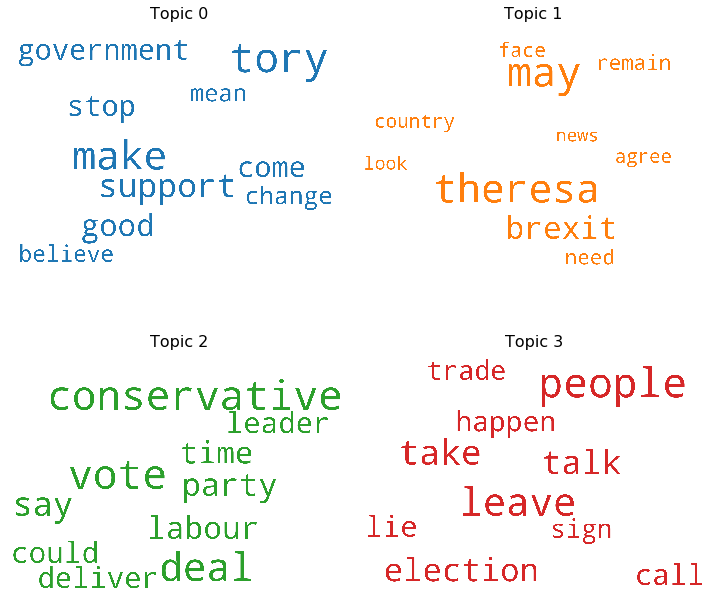

In [1117]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_m.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
#plt.show()

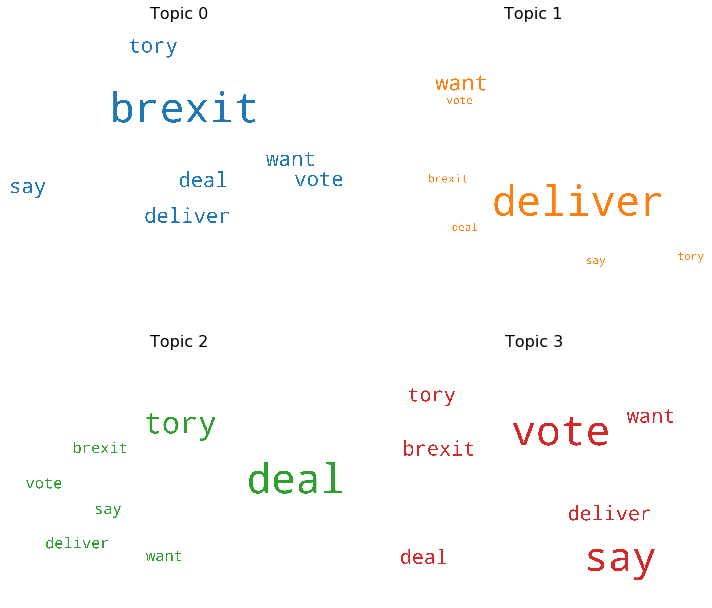

In [1135]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_j.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
#plt.show()

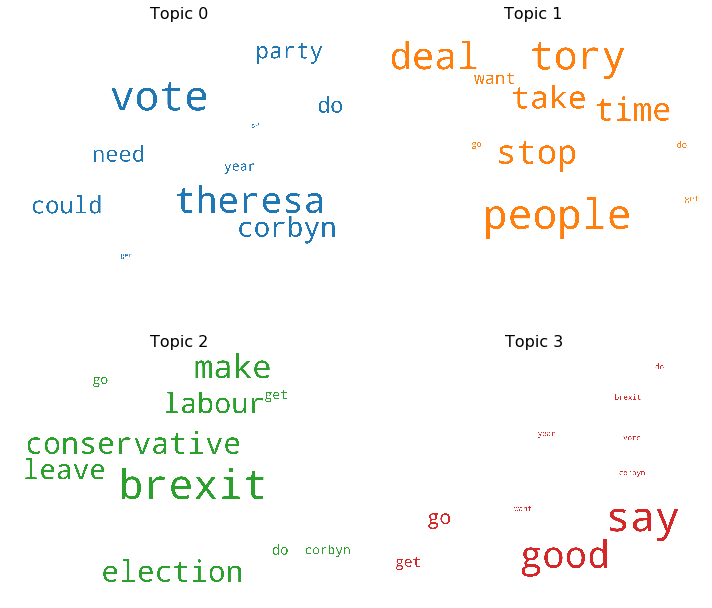

In [1142]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_n.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
#plt.show()

In [281]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=tfidf_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [272]:
df_top3words

,topic_id,words
0,0,"could, \nyear, \nknow"
1,1,"vote, \ntory, \nelection"
2,5,"leave, \ngo, \ntake"
3,7,"conservative, \ntheresa, \nlabour"
4,10,"deal, \npoint, \npolitical"
5,13,"deliver, \ngood, \ngovernment"
6,14,"hold, \npower, \nfeel"
7,15,"look, \nlast, \nhard"
8,16,"head, \nword, \nquestion"
9,18,"may, \nremain, \ntoday"


In [1146]:
lda_data =  pyLDAvis.gensim.prepare(lda_model_n, tfidf_corpus_n, id2word_n, mds='mmds')
pyLDAvis.display(lda_data)

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


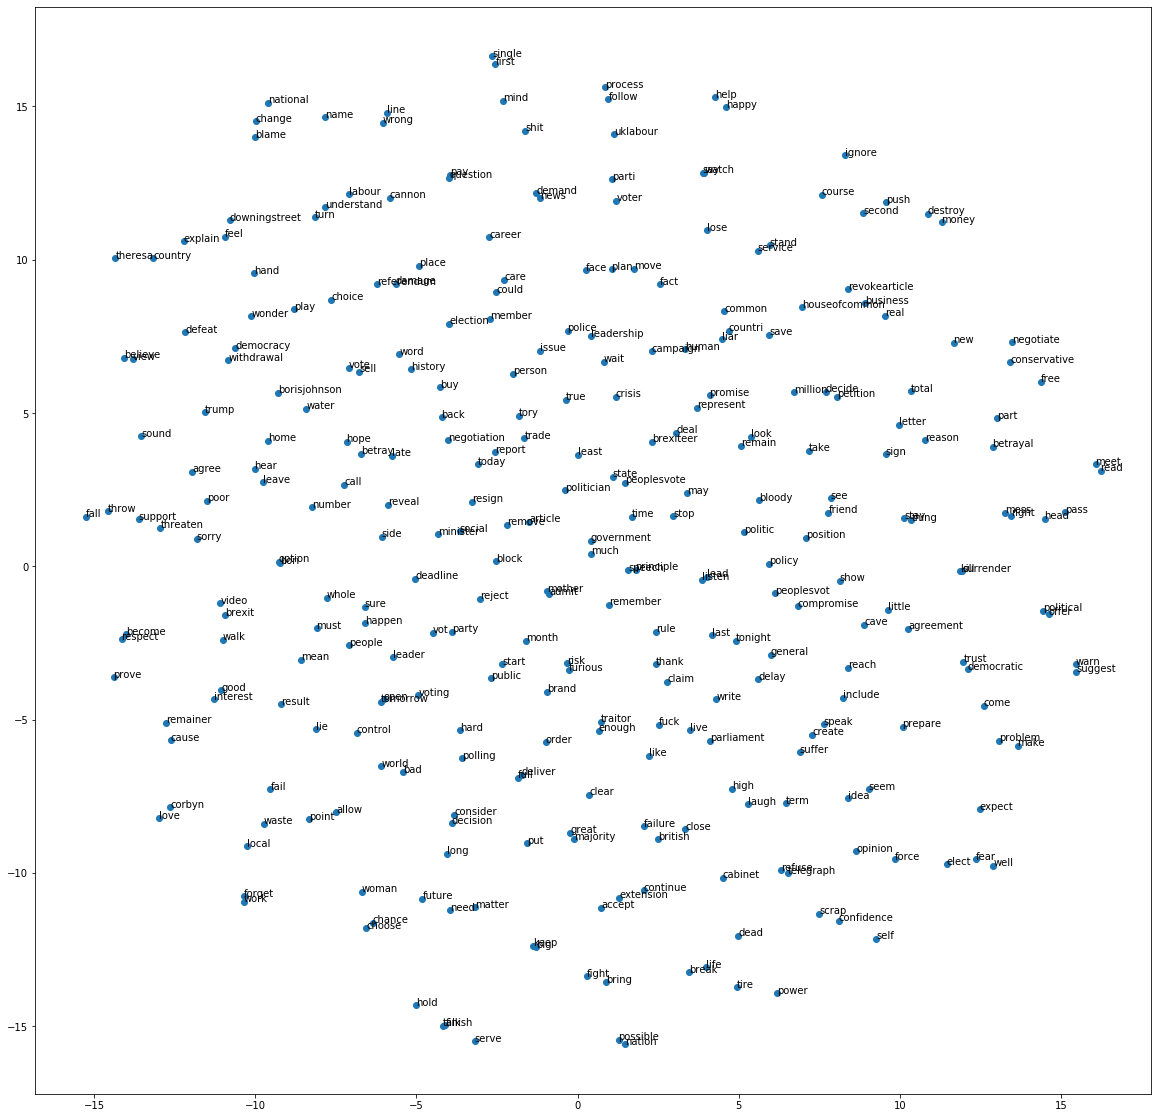

In [1167]:
vocab = list(w2v_model_m.wv.vocab)
X = w2v_model_m[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:1000,:])
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)